In [324]:
import numpy as np

np.load

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import os

experiment_key = "078_wiki_reversed"
choose_metric = "mse"

hyperparam1_labels= ["3 Clusters", "4 Clusters", "5 Clusters", "6 Clusters", "7 Clusters"]
# hyperparam1_labels= ["3 Clusters", "5 Clusters", "7 Clusters"]
# hyperparam2_labels=["1 supervised", "2 supervised", "3 supervised"]
hyperparam2_labels=["1 supervised", "2 supervised", "3 supervised", "4 supervised"]
model_labels= ['Bridged Clustering', 'KNN', 'MeanTeacher', 'FixMatch', 'Laplacian RLS', 'TSVR', 'TNNR', 'UCVME', 'RankUp','GCN', 'KMM','EM']

ami_x = np.load(f"results/{experiment_key}/ami_x.npy")
ami_y = np.load(f"results/{experiment_key}/ami_y.npy")
mae = np.load(f"results/{experiment_key}/mae.npy")
mse = np.load(f"results/{experiment_key}/mse.npy")
accuracy = np.load(f"results/{experiment_key}/accuracy.npy")
# if exists:
if os.path.exists(f"results/{experiment_key}/bleu.npy"):
    bleu = np.load(f"results/{experiment_key}/bleu.npy")
    chrf = np.load(f"results/{experiment_key}/chrf.npy")

In [325]:
if ami_x.ndim == 5:
    ami_x = ami_x[:, 0, :, 0, :]
    ami_y = ami_y[:, 0, :, 0, :]
    accuracy = accuracy[:, 0, :, 0, :]
    mae = mae[:, 0, :, 0, :, :]
    mse = mse[:, 0, :, 0, :, :]

print("ami_x shape:", ami_x.shape)
print("ami_y shape:", ami_y.shape)
print("accuracy shape:", accuracy.shape)
print("mae shape:", mae.shape)
print("mse shape:", mse.shape)
# print("bleu shape:", bleu.shape)
if choose_metric == "mae":
    metric = mae
elif choose_metric == "mse":
    metric = mse
elif choose_metric == "bleu":
    metric = bleu
else:
    metric = chrf

ami_x shape: (5, 4, 30)
ami_y shape: (5, 4, 30)
accuracy shape: (5, 4, 30)
mae shape: (5, 4, 12, 30)
mse shape: (5, 4, 12, 30)


['3 Clusters', '4 Clusters', '5 Clusters', '6 Clusters', '7 Clusters']
['1 supervised', '2 supervised', '3 supervised', '4 supervised']


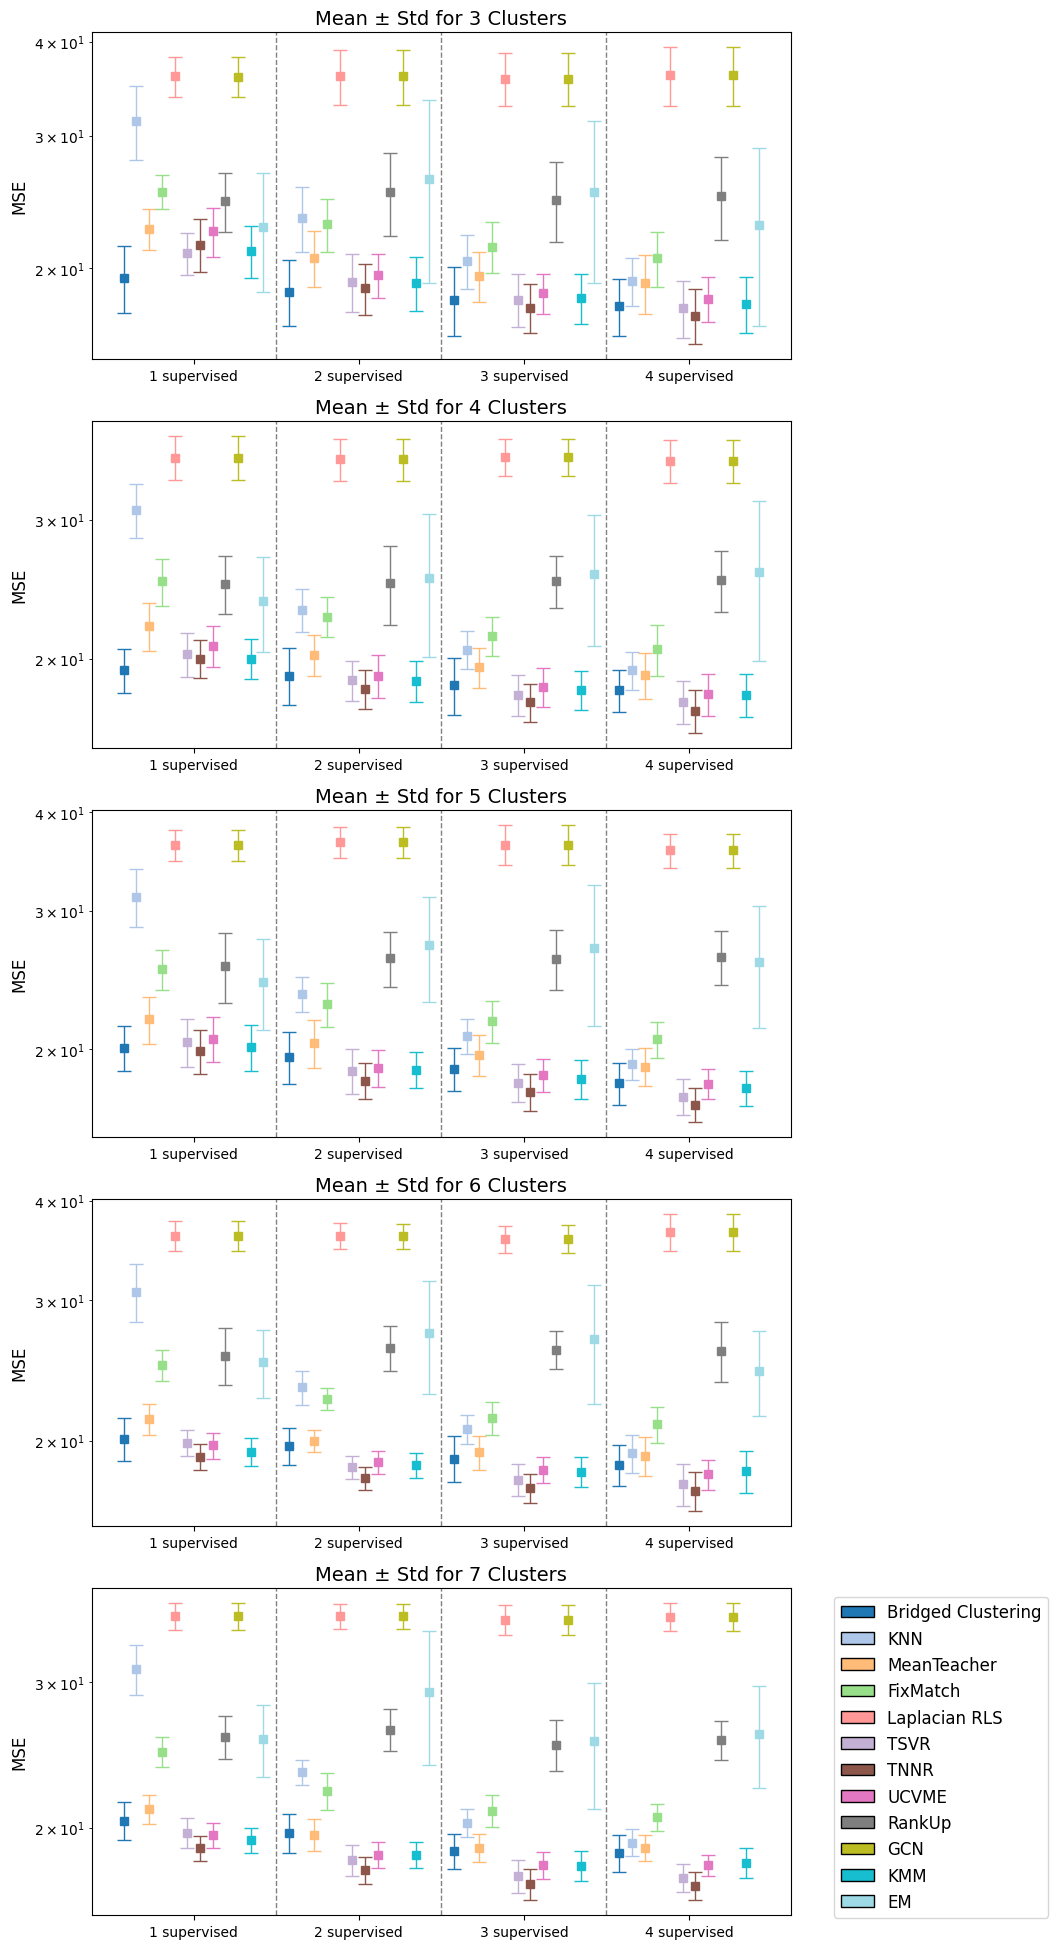

In [326]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

def plot_boxplots_by_hyper1(loss_data: np.ndarray,
                            metric_name="MAE",
                            hyperparam1_labels=None,
                            hyperparam2_labels=None,
                            model_labels=None,
                            log_scale=False):
    """
    Create a figure with one subplot per hyperparam1 value.
    In each subplot, for each hyperparam2 group and model you get
    a point at the mean loss ± std-dev as error bars.
    """
    # unwrap leading singleton dim
    if loss_data.ndim == 5 and loss_data.shape[0] == 1:
        loss_data = loss_data[0]
    num_h1, num_h2, num_models, num_trials = loss_data.shape

    # default labels
    if hyperparam1_labels is None:
        hyperparam1_labels = [f'H1-{i}' for i in range(num_h1)]
    if hyperparam2_labels is None:
        hyperparam2_labels = [f'H2-{i}' for i in range(num_h2)]
    if model_labels is None:
        model_labels = [f'Model {i+1}' for i in range(num_models)]

    cmap = plt.get_cmap('tab20', num_models)
    colors = [cmap(i) for i in range(num_models)]

    fig, axes = plt.subplots(nrows=num_h1, ncols=1,
                             figsize=(12, 4 * num_h1), sharex=False)
    if num_h1 == 1:
        axes = [axes]

    for i, ax in enumerate(axes):
        positions = []
        group_centers = []
        group_positions = []
        gap = 1

        # collect means & stds in flat lists
        means, stds = [], []

        for j in range(num_h2):
            base = j * (num_models + gap)
            pos = list(range(base + 1, base + 1 + num_models))
            group_positions.append(pos)
            group_centers.append(np.mean(pos))

            for m in range(num_models):
                vals = loss_data[i, j, m, :]
                means.append(vals.mean())
                stds.append(vals.std(ddof=0))
                positions.append(pos[m])

        # plot error bars
        for idx, (x, mu, sigma) in enumerate(zip(positions, means, stds)):
            model_idx = idx % num_models
            ax.errorbar(x, mu, yerr=sigma,
                        fmt='s', markersize=6,
                        capsize=5, elinewidth=1,
                        color=colors[model_idx], label=None)

        # separators
        for j in range(len(group_positions)-1):
            x0 = (group_positions[j][-1] + group_positions[j+1][0]) / 2
            ax.axvline(x=x0, linestyle='--', linewidth=1, color='gray')

        ax.set_xticks(group_centers)
        ax.set_xticklabels(hyperparam2_labels, fontsize=10)
        ax.set_ylabel(metric_name, fontsize=12)
        ax.set_title(f"Mean ± Std for {hyperparam1_labels[i]}", fontsize=14)
        if log_scale:
            ax.set_yscale("log")

    # legend
    legend_handles = [
        Patch(facecolor=colors[k], edgecolor='k', label=model_labels[k])
        for k in range(num_models)
    ]
    plt.legend(handles=legend_handles,
               bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)

    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.show()


print(hyperparam1_labels)
print(hyperparam2_labels)
plot_boxplots_by_hyper1(metric,
                        metric_name=choose_metric.upper(),
                        hyperparam1_labels=hyperparam1_labels,
                        hyperparam2_labels=hyperparam2_labels,
                        model_labels=model_labels,
                        log_scale=True)

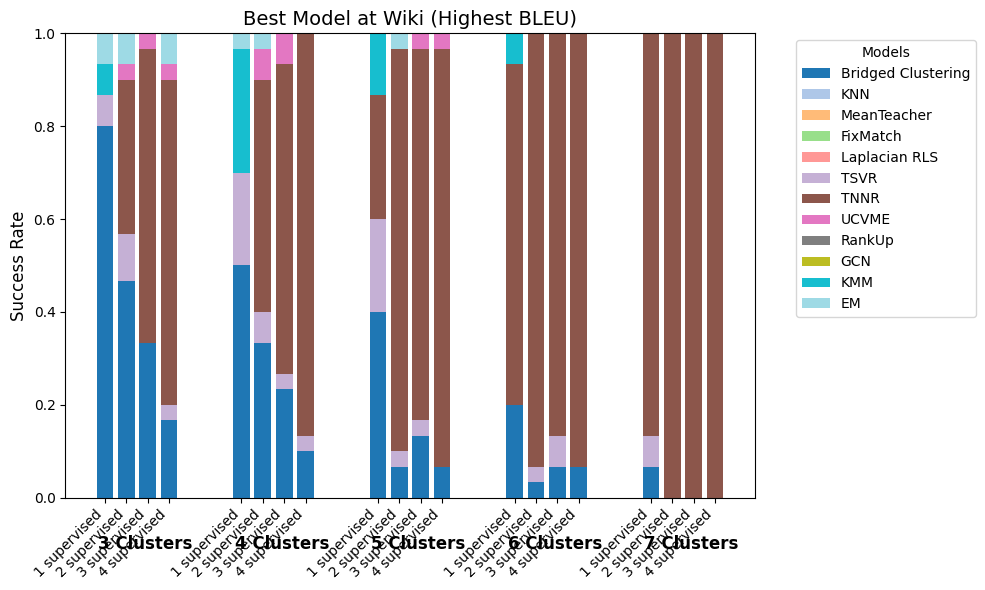

In [327]:
import numpy as np
import matplotlib.pyplot as plt

# --- Assumes you already have total_results_matrix of shape (3, 4, n_models, n_trials) ---
n_h1, n_h2, n_models, n_trials = metric.shape

# 1) Compute success rates
success_rates = np.zeros((n_h1, n_h2, n_models))
for i in range(n_h1):
    for j in range(n_h2):
        losses = metric[i, j]        # (n_models, n_trials)
        if choose_metric == "bleu" or choose_metric == "chrf":
            winners = np.argmax(losses, axis=0)
        else:
            winners = np.argmin(losses, axis=0)
        for k in range(n_models):
            success_rates[i, j, k] = np.mean(winners == k)

# 2) Layout parameters
bar_width   = 0.18
intra_gap   = 0.05
group_gap   = 0.6
group_width = n_h2 * bar_width + (n_h2 - 1) * intra_gap

# Build x‐positions for each of the 12 bars
positions = []
for i in range(n_h1):
    base = i * (group_width + group_gap)
    for j in range(n_h2):
        x = base + j * (bar_width + intra_gap)
        positions.append(x)
positions = np.array(positions)

# 3) Pick n_models distinct colors
cmap   = plt.get_cmap('tab20')
colors = [cmap(t) for t in np.linspace(0, 1, n_models)]

# 4) Plot the stacked bars
fig, ax = plt.subplots(figsize=(10, 6))
for idx, x in enumerate(positions):
    i = idx // n_h2    # which hyperparam1 group
    j = idx % n_h2     # which hyperparam2 bar in that group
    bottom = 0.0
    for k in range(n_models):
        rate = success_rates[i, j, k]
        ax.bar(x, rate, bar_width, bottom=bottom, color=colors[k])
        bottom += rate

# 5) Secondary ticks for hyperparam2_labels
ax.set_xticks(positions)
# repeat hyperparam2_labels for each hyperparam1 group
ax.set_xticklabels(hyperparam2_labels * n_h1, rotation=45, ha='right', fontsize=10)

# 6) Add hyperparam1 group labels centered beneath the bars
group_centers = [
    i * (group_width + group_gap) + group_width / 2
    for i in range(n_h1)
]
for i, center in enumerate(group_centers):
    ax.text(center, -0.08, hyperparam1_labels[i],
            transform=ax.get_xaxis_transform(),
            ha='center', va='top', fontsize=12, fontweight='bold')

ax.set_ylabel("Success Rate", fontsize=12)
ax.set_ylim(0, 1)
ax.set_title("Best Model at Wiki (Highest BLEU)", fontsize=14)

# 7) Legend
ax.legend(model_labels, bbox_to_anchor=(1.05, 1),
          loc='upper left', title="Models")

plt.tight_layout()
plt.show()

In [328]:
import numpy as np
from scipy.stats import friedmanchisquare, rankdata, wilcoxon
from statsmodels.stats.multitest import multipletests

# Your result tensor: (3, 4, 13, 20) → reshape to (12 settings, 13 models, 20 trials)
results_reshaped = metric.reshape(-1, 12, 30)  # shape: (12, 13, 20)

# Stack all setting/trial dimensions: shape → (13 models, 12×20 trials)
n_settings, n_models, n_trials = results_reshaped.shape
data_per_model = results_reshaped.transpose(1, 0, 2).reshape(n_models, -1)  # shape: (13, 240)

# Run Friedman test (input: list of arrays, one per model)
friedman_stat, friedman_p = friedmanchisquare(*data_per_model)
print(f"Friedman test statistic = {friedman_stat:.3f}, p-value = {friedman_p:.3g}")

# Post-hoc: Wilcoxon signed-rank test between BKM (index 0) and others
p_values = []
stat_values = []

bkm_scores = data_per_model[0]
for i in range(1, n_models):
    stat, p = wilcoxon(bkm_scores, data_per_model[i])
    stat_values.append(stat)
    p_values.append(p)

# Corrections
_, p_bonf, _, _ = multipletests(p_values, method='bonferroni')
_, p_bh, _, _ = multipletests(p_values, method='fdr_bh')

# Display post-hoc results
print("\nWilcoxon test: BKM vs each baseline")
for i, (raw, bonf, bh) in enumerate(zip(p_values, p_bonf, p_bh), start=1):
    print(f"Baseline {i:<2}: raw p = {raw:.3g}, Bonferroni = {bonf:.3g}, BH = {bh:.3g}")

Friedman test statistic = 5787.013, p-value = 0

Wilcoxon test: BKM vs each baseline
Baseline 1 : raw p = 6e-97, Bonferroni = 6.6e-96, BH = 1.1e-96
Baseline 2 : raw p = 2.88e-51, Bonferroni = 3.17e-50, BH = 4.53e-51
Baseline 3 : raw p = 2.06e-99, Bonferroni = 2.26e-98, BH = 5.65e-99
Baseline 4 : raw p = 5.98e-100, Bonferroni = 6.58e-99, BH = 2.28e-99
Baseline 5 : raw p = 1.86e-17, Bonferroni = 2.05e-16, BH = 2.28e-17
Baseline 6 : raw p = 2.84e-43, Bonferroni = 3.13e-42, BH = 3.91e-43
Baseline 7 : raw p = 0.0573, Bonferroni = 0.63, BH = 0.0573
Baseline 8 : raw p = 6.22e-100, Bonferroni = 6.84e-99, BH = 2.28e-99
Baseline 9 : raw p = 5.98e-100, Bonferroni = 6.58e-99, BH = 2.28e-99
Baseline 10: raw p = 1.12e-09, Bonferroni = 1.23e-08, BH = 1.23e-09
Baseline 11: raw p = 1.88e-97, Bonferroni = 2.07e-96, BH = 4.14e-97
